## Use feature-weighted rf model on the crcns vim-1 dataset

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from theano import tensor as tnsr
from theano import function, scan
from time import time
from scipy.signal import convolve2d as conv2d
from hrf_fitting.src.features import make_gaussian, construct_placement_grid
from glob import glob
from scipy.io import loadmat
from hrf_fitting.src.feature_weighted_rf_models import apply_rf_to_feature_maps, bigmult, compute_grad,sq_diff_func
from hrf_fitting.src.features import make_complex_gabor as gaborme
from PIL import Image
from scipy.stats import pearsonr



Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX TITAN X


### Step 1: construct feature maps

In [2]:
Df, Do = 1, 8  #Df = sp. freq. divisions, Do = orientations
D = Df*Do + 1  # +1 for a bias dimension

#### load crcns stimuli

In [3]:
stim_location = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli.mat'
crcns_stim_dict = loadmat(stim_location)

In [4]:
##need 'stimVal' and 'stimTrn'
print crcns_stim_dict['stimVal'].shape
print crcns_stim_dict['stimTrn'].shape

(120, 128, 128)
(1750, 128, 128)


In [5]:
##remember stim params
Ttrn = crcns_stim_dict['stimTrn'].shape[0]
Tval = crcns_stim_dict['stimVal'].shape[0]
T = Ttrn+Tval
native_stim_size = crcns_stim_dict['stimTrn'].shape[1]
n_image_channels = 1 ##could be 3 for color images.
stim_size = 64


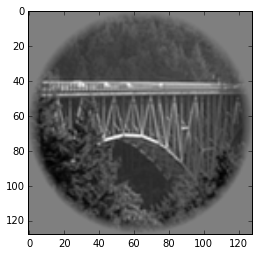

In [6]:
plt.imshow(crcns_stim_dict['stimVal'][0,:,:],cmap='gray')

#### construct gabor wavelet stack

In [10]:
##parameters for designing gabor feature maps
##specify frequencies in cycles_per_pixel, use to determine size of prf.
##should probably specify in cycles per deg.

pixel_per_deg = 25*(stim_size/500.)    ##determined by experiment 34.751 = match/nonmatch exp.
pixels_per_stimulus = stim_size ##det. by exp. 768 = match/nonmatch exp.
cycles_per_deg = 1.5*np.logspace(0,1.5,num=Df)
cycles_per_pixel = cycles_per_deg/pixel_per_deg  ##cyc/pix
cycles_per_fwhm = 2.0
fwhms_per_kernel = 2.0 ##determines how big the picture of the gabor will be.

metrics = {'cycles per pixel':cycles_per_pixel,
           'pixels per cycle': 1./cycles_per_pixel,
           'cycles per stimulus': cycles_per_pixel*pixels_per_stimulus,
           'cycles per deg.': cycles_per_deg,
           'fwhm (pix)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus),
           'prf_size (deg)': np.clip(cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)/pixel_per_deg/2.,
           'n_pix': np.clip(fwhms_per_kernel*cycles_per_fwhm/cycles_per_pixel,0,pixels_per_stimulus)}

fm = pd.DataFrame(metrics)
fm

,cycles per deg.,cycles per pixel,cycles per stimulus,fwhm (pix),n_pix,pixels per cycle,prf_size (deg)
0,1.5,0.46875,30,4.266667,8.533333,2.133333,0.666667


In [67]:
pixel_per_deg*4.2667

13.653440000000002

In [68]:
0.46875*4.266

1.9996875

In [11]:
oris = np.linspace(0, 2*np.pi, num=Do, endpoint=False)

In [64]:
oris

array([ 0.        ,  0.78539816,  1.57079633,  2.35619449,  3.14159265,
        3.92699082,  4.71238898,  5.49778714])

#### generate feature maps

In [12]:
##--make a theano function for this
stim_tnsr = tnsr.tensor4('stim_tnsr')  ##T x n_image_channels x stim_size x stim_size
real_filter_stack_tnsr = tnsr.tensor4('real_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
imag_filter_stack_tnsr = tnsr.tensor4('imag_feature_map_tnsr') ##D x n_image_channels x stim_size x stim_size. complex
filter_stack_tnsr_shape = (1, n_image_channels,stim_size,stim_size)
real_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 real_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
                                 filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps
imag_feature_map_tnsr = tnsr.nnet.conv2d(stim_tnsr,
                                 imag_filter_stack_tnsr,
                                 image_shape = (1,n_image_channels,stim_size,stim_size),
                                 filter_shape = filter_stack_tnsr_shape,
                                 border_mode = 'full')  ##produces T x D x stim_size x stim_size maps

##for filtering with complex gabors, we need an operation for squaring/summing real/imag parts

abs_value = tnsr.sqrt(tnsr.sqr(real_feature_map_tnsr) + tnsr.sqr(imag_feature_map_tnsr))
##functionize feature mapping
make_feature_maps = function(inputs = [stim_tnsr,real_filter_stack_tnsr,imag_filter_stack_tnsr],
                             outputs = abs_value)

In [ ]:
##create filter stack, but separate real/imag parts because theano doesn't like complex numbers
##here we leave Dth filter at zero because later we will add a "bias" feature of all 1's.
filter_channels = 2
filter_stack = np.zeros((D, filter_channels, stim_size, stim_size)).astype('float32')
f_counter = 0
feature_map_params = []
for df in range(Df):
    for do in range(Do):
        ori = oris[do]
        center = (0,0)
        freq = fm.loc[df,'cycles per stimulus']
        fwhm = fm.loc[df,'fwhm (pix)']
        n_pix = stim_size
        feature_map_params.append( (ori,freq,fwhm,n_pix) )
        tmp_filter = gaborme(freq,ori,center,fwhm,n_pix)
        filter_stack[f_counter,0,:,:] = np.real(tmp_filter).astype('float32')
        filter_stack[f_counter,1,:,:] = np.imag(tmp_filter).astype('float32')
        f_counter += 1
##show imag. part of some filter    

(9, 2, 64, 64)


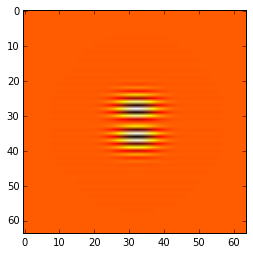

In [85]:
plt.imshow(filter_stack[0,1,:,:],cmap='hot')
print filter_stack.shape

(9, 2, 64, 64)


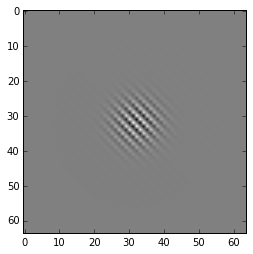

In [13]:
feature_map_params = pd.DataFrame(data=feature_map_params,columns=['ori','freq','fwhm','n_pix'])

In [14]:
feature_map_params.head(12)

,ori,freq,fwhm,n_pix
0,0.000000,30,4.266667,64
1,0.785398,30,4.266667,64
2,1.570796,30,4.266667,64
3,2.356194,30,4.266667,64
4,3.141593,30,4.266667,64
5,3.926991,30,4.266667,64
6,4.712389,30,4.266667,64
7,5.497787,30,4.266667,64


In [61]:
feature_maps = np.zeros((T,D,stim_size,stim_size))
stimuli = np.concatenate((crcns_stim_dict['stimVal'],crcns_stim_dict['stimTrn']),axis=0)
for d in range(Df*Do):
    start = time()
    for t in range(T):
        
        this_stim = np.array(Image.fromarray(stimuli[t,:,:]).resize((stim_size,stim_size))).astype('float32')
        this_stim = this_stim[np.newaxis,np.newaxis,:,:]
        tmp_feature_map = make_feature_maps(this_stim,
                                            np.reshape(filter_stack[d,0,:,:], (1,n_image_channels,stim_size,stim_size)),
                                            np.reshape(filter_stack[d,1,:,:], (1,n_image_channels,stim_size,stim_size)))
    
        ##crop because convolution
        new_size = tmp_feature_map.shape[2]
        crop_start = np.round((new_size-stim_size)/2.).astype('int')
        crop_stop = crop_start+stim_size
        feature_maps[t,d,:,:] = tmp_feature_map[:, :, crop_start:crop_stop, crop_start:crop_stop]
    print 'feature %d took %0.3f' %(d,time()-start)
print feature_maps.shape


feature 0 took 7.041
feature 1 took 6.897
feature 2 took 6.954
feature 3 took 6.904
feature 4 took 6.920
feature 5 took 6.914
feature 6 took 7.104
feature 7 took 7.657
(1870, 9, 64, 64)


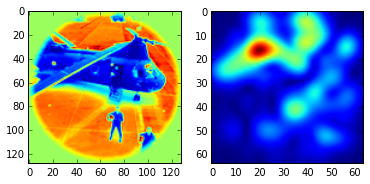

In [62]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(stimuli[-1,:,:])
plt.subplot(1,2,2)
plt.imshow(feature_maps[-1,0,:,:])

In [63]:
from scipy.io import savemat
fm_dict = {}
fm_dict['fmap'] = feature_maps
savemat('/media/tnaselar/Data/scratch/test_fm.mat',fm_dict)

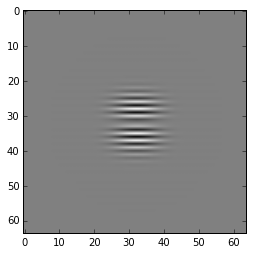

In [17]:
plt.imshow(np.real(filter_stack[0,1,:,:]), cmap='gray')

In [18]:
##force float 32 explicitly
feature_maps = feature_maps.astype('float32')

### Step 2: construct model_space

#### create receptive field model stack

In [19]:
Gx,Gy,Gw = 16,16,Df
G = Gx*Gy*Gw

In [20]:
def space_time_kernel(center, fwhm, n_pix, time_kernel):
    '''
    a separable space-time kernel.
    space kernel is gaussian
    time kernel is an array of length T
    returns a 3-D volume that is (n_pix,n_pix,T)
    slice it to see what it does.
    '''
    space_kernel = np.atleast_3d(make_gaussian(center,fwhm,n_pix))
    return time_kernel*space_kernel
    

In [21]:
##dumb grid
##create filter stack, but separate real/imag parts because theano doesn't like complex numbers
g_counter = 0
half_stim_size = np.round(stim_size/2.).astype('int')
g_rows, g_cols = construct_placement_grid([-half_stim_size,half_stim_size,-half_stim_size,half_stim_size],np.round(stim_size/Gx).astype('int'))
rf_stack = np.zeros((Gx*Gy*Gw, stim_size, stim_size)).astype('float32')
rf_params = []
for gw in fm['fwhm (pix)']:
    for gx,gy in zip(g_rows.ravel(),g_cols.ravel()):
            center = (gx,gy)
            fwhm = gw
            rf_stack[g_counter,:,:] = np.squeeze(space_time_kernel(center, fwhm, stim_size, 1)).astype('float32')
            g_counter += 1
            rf_params.append( (gx,gy,fwhm) )
rf_params = pd.DataFrame(data=rf_params,columns=['x','y','fwhm'])

(256, 64, 64)


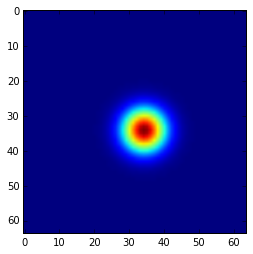

In [49]:
plt.imshow(rf_stack[136,:,:])
print rf_stack.shape

In [23]:
rf_params.head()

,x,y,fwhm
0,-32.000000,-32,4.266667
1,-27.733333,-32,4.266667
2,-23.466667,-32,4.266667
3,-19.200000,-32,4.266667
4,-14.933333,-32,4.266667


In [45]:
np.unique(rf_params.fwhm)

array([ 4.26666667])

#### apply rf stack to feature maps to construct model_space

In [24]:
model_space = np.zeros((G,T,D))
for t in range(T):
    start = time()
    model_space[:,np.newaxis,t,:] = apply_rf_to_feature_maps(rf_stack, feature_maps[t,np.newaxis,:,:])
    if (t % 100) == 0:
        print time()-start

0.079754114151
0.00158309936523
0.00171685218811
0.00155711174011
0.00158500671387
0.00156903266907
0.0015709400177
0.00156188011169
0.00155591964722
0.00155687332153
0.00155687332153
0.00155711174011
0.00157594680786
0.00156497955322
0.00156497955322
0.00171804428101
0.0018470287323
0.00155687332153
0.0016028881073


#### normalize the model space. THIS IS ABSOLUTELY ESSENTIAL!

In [25]:
#### normalize model space and add a column of 1's to each model: 
model_space = model_space - np.expand_dims(np.mean(model_space,axis=1),axis=1)
model_space = model_space / np.expand_dims(np.std(model_space,axis=1),axis=1)
model_space[:,:,-1] = 1


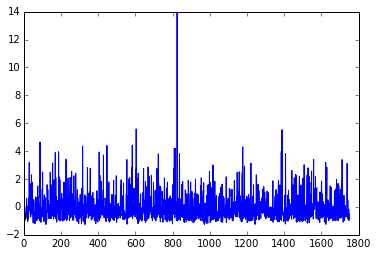

In [51]:
plt.plot(model_space[136, :1750, 0])

In [26]:
##clear up some memory
feature_maps = []

In [27]:
model_space = model_space.astype('float32')

### Step 3: train model on real data

#### load voxel data

In [53]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file)
crcns_voxel_data.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

In [54]:
Vs1 = crcns_voxel_data['dataTrnS1'].shape[1]
print Vs1

25915


#### remove nans, becuase this data-set has some. otherwise even one nan will infect gradient for every voxel.

In [55]:
voxel_data = np.concatenate((crcns_voxel_data['dataValS1'],crcns_voxel_data['dataTrnS1']),axis=0).astype('float32')

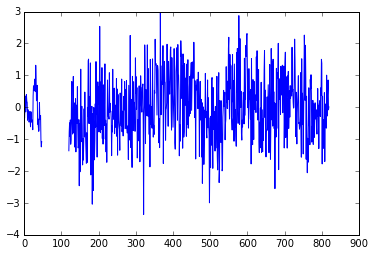

In [57]:
plt.plot(voxel_data[:, -1])

In [30]:
no_nan = np.isnan(crcns_voxel_data['dataTrnS1']).sum(axis=0) == 0 ##<<only pulled voxels with nans in training data, should pull if nans in val data too.
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1]

(1870, 22733)


In [31]:
np.sum(np.isnan(voxel_data))

384

#### the training function

In [32]:
def train_fwrf_model(model_space, voxel_data,initial_feature_weights,
                     early_stop_fraction = 0.2,
                     max_iters=100,
                     mini_batch_size = 0.1,
                     learning_rate=10**(-5),
                     voxel_binsize=100,
                     rf_grid_binsize = 200,
                     report_every = 10):

    ##basic dimenisions
    G,T,D = model_space.shape ##G = size of rf grid, T = number of trials (timepoints), D = number of feature weights
    _,V = voxel_data.shape ##V = number of voxels

    ##chunk up the voxels
    trnIdx = np.arange(0,T)
    early_stop_num = np.round(len(trnIdx)*early_stop_fraction).astype('int')
    voxel_bin_num = max(2,np.round(V/voxel_binsize))
    voxel_bins = np.linspace(0,V-1,num=voxel_bin_num,endpoint=True)

    ##chunk up the rf grids
    gdx = np.arange(0,G)
    rf_bin_num = np.round(G/rf_grid_binsize)
    rf_bins = np.linspace(0,G-1,num=rf_bin_num,endpoint=True)

    ##clock the whole function execution.
    big_start = time()
            
    ##prepare indices for data split
    perm_dx = np.random.permutation(trnIdx)
    validation_idx = perm_dx[0:early_stop_num]
    training_idx = perm_dx[early_stop_num:]
    validation_idx = np.atleast_2d(np.sort(validation_idx).astype('int')) ##1 x val_idx.shape[1]
    training_idx = np.atleast_2d(np.sort(training_idx).astype('int')) ##1 x trn_idx.shape[1]
    
    ##for storing the final model for each voxel
    final_rf = np.zeros(V).astype('int')
    final_feature_weights = np.zeros((D,V)).astype('float32')
    final_validation_loss = np.inf*np.ones(V)
    
    ####store error history of best rf model for each voxel
    best_error_history = np.zeros((max_iters,V))
    
    ##iterate over batches of voxels
    for v in range(len(voxel_bins)-1):
        
        ##indices for current batch of voxels
        v_idx = np.atleast_2d(np.arange(voxel_bins[v], voxel_bins[v+1]).astype('int')) ##1 x v_idx.shape[1]
        this_vox_batch_size = v_idx.shape[1]
        print '--------------voxels from %d to %d' %(v_idx[0,0],v_idx[0,-1])
        
        ##get data for these voxels
        this_trn_voxel_data = voxel_data[training_idx.T, v_idx]
        this_val_voxel_data = voxel_data[validation_idx.T, v_idx]
        
        
        ##iterate over batches of rf models
        for g in range(len(rf_bins)-1):
            
            ##indices for current batch of rf models
            rf_idx = np.atleast_2d(np.arange(rf_bins[g], rf_bins[g+1]).astype('int')) ##1 x rf_idx.shape[1]
            this_rf_batch_size = rf_idx.shape[1]
            print '--------candiate rf models %d to %d' %(rf_idx[0,0],rf_idx[0,-1])
            
            ##slice model space for this batch of models / this batch of voxels
            this_trn_model_space = model_space[rf_idx.T,training_idx,:]
            this_val_model_space = model_space[rf_idx.T,validation_idx,:]

            ##initialize best and current loss containers for this batch of voxels/models
            best_validation_loss = Inf*np.ones((this_rf_batch_size,this_vox_batch_size)) #rf_chunk x voxel_chunk
            this_validation_loss = np.zeros(best_validation_loss.shape)
            
            ##initialize best and current weight containers for this batch of voxels/models
            best_feature_weights = initial_feature_weights[rf_idx.flatten(),:,:]
            best_feature_weights = best_feature_weights[:,:,v_idx.flatten()]
            feature_weights = copy(best_feature_weights)
            
            
            ##initialize reports. so you can waste an entire afternoon watching your models train.
            iter_error = np.zeros((max_iters, this_vox_batch_size))
            bestie_change = np.zeros(max_iters)
            old_besties = np.zeros(this_vox_batch_size)
            
            ##initialize counters
            iters = 0
            start = time()
                        
            ##take gradient steps for a fixed number of iterations
            while (iters < max_iters):
                
                ##gradient: put a loop here over chunks of rf models to save on memory
                d_loss_wrt_params = compute_grad(this_trn_voxel_data,
                                                 this_trn_model_space,
                                                 feature_weights)
                
                
                ##update feature weights
                feature_weights -= learning_rate * d_loss_wrt_params
                
                ##predictions with updated feature weights
                prediction_menu = bigmult(this_val_model_space,
                                          feature_weights)

                ##updated loss
                this_validation_loss = sq_diff_func(this_val_voxel_data,
                                                    prediction_menu)
                
                ##if new loss minimum, save as best
                improved = this_validation_loss < best_validation_loss  ##rf batch x voxel batch
                imp = np.sum(improved)
                for ii in range(this_rf_batch_size):
                    best_validation_loss[ii,improved[ii,:]] = copy(this_validation_loss[ii,improved[ii,:]])
                    best_feature_weights[ii,:,improved[ii,:]] = copy(feature_weights[ii,:,improved[ii,:]])
                
                ##reporting business
                iter_error[iters,:]  = np.min(this_validation_loss,axis=0)
                besties = np.argmin(this_validation_loss,axis=0)
                bestie_change[iters] = np.sum(besties - old_besties)
                old_besties = copy(besties)
                if iters % report_every == 0:
                    print '-------'
                    print 'errors: %f' %(np.nanmean(iter_error[iters,:]))
                    print 'change in best rf: %f' %(bestie_change[iters])
                    print 'norm of feature weights: %f' %(np.sqrt(np.sum(feature_weights*feature_weights)))
                    print 'improvements: %d' %(imp)
                    print time()-start
                    start = time()
                
                ##update iteration
                iters += 1
            
            ##if the best of this batch of models has achieved new loss minimum, save it.
            for ii in range(this_vox_batch_size):
                best_of_batch_rf = np.argmin(best_validation_loss[:,ii]) ##index into current rf batch
                this_voxel = v_idx.flatten()[ii] ##total voxel index 
                if best_validation_loss[best_of_batch_rf,ii] < final_validation_loss[this_voxel]:
                    final_validation_loss[this_voxel] = copy(best_validation_loss[best_of_batch_rf,ii])
                    final_feature_weights[:,this_voxel] = copy(best_feature_weights[best_of_batch_rf,:,ii])
                    final_rf[this_voxel] = rf_idx[0,best_of_batch_rf]
                    best_error_history[:,this_voxel] = copy(iter_error[:,ii])

    print time()-big_start
    return final_validation_loss,final_feature_weights,final_rf,best_error_history


#### grab training data

In [33]:
nvox=-1
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]
trn_model_space = model_space[:,trnIdx,:]

#### train the model!

In [34]:
fvl,ffw,frf,beh = train_fwrf_model(trn_model_space,
                 trn_voxel_data,
                 np.zeros((G,D,V)).astype('float32'),
                 voxel_binsize = 1000,
                 rf_grid_binsize=40,
                 learning_rate=10**(-5.0),
                 max_iters = 50,
                 early_stop_fraction=0.2,
                 report_every = 25)

--------------voxels from 0 to 1082
--------candiate rf models 0 to 50
-------
errors: 347.999076
change in best rf: 28248.000000
norm of feature weights: 0.568273
improvements: 55233
0.135880947113
-------
errors: 346.572232
change in best rf: -29.000000
norm of feature weights: 7.011845
improvements: 10586
2.9387588501
--------candiate rf models 51 to 101
-------
errors: 348.001011
change in best rf: 27210.000000
norm of feature weights: 0.543405
improvements: 55233
0.123378038406
-------
errors: 346.481433
change in best rf: 0.000000
norm of feature weights: 7.097168
improvements: 10826
2.92545104027
--------candiate rf models 102 to 152
-------
errors: 348.026813
change in best rf: 26511.000000
norm of feature weights: 0.544584
improvements: 55233
0.118740081787
-------
errors: 346.513741
change in best rf: 91.000000
norm of feature weights: 7.276503
improvements: 11118
2.99319005013
--------candiate rf models 153 to 203
-------
errors: 348.045884
change in best rf: 27407.000000
no

#### loss histories, all voxels

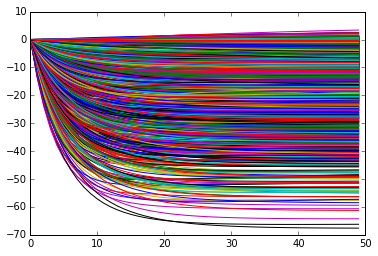

In [35]:
_=plt.plot(beh-beh[0,:])


#### view loss history for a few voxels

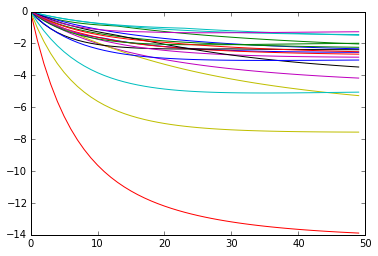

In [36]:
_=plt.plot(beh[:,slice(0,-1,1200)]-beh[0,slice(0,-1,1200)])

In [37]:
##loss in "final_validation_loss" = last point of "best_error_history"
print np.min(beh[:,-2])
print fvl[-2]

288.786895752
288.786895752


#### diff between first and last point of loss history, all voxels

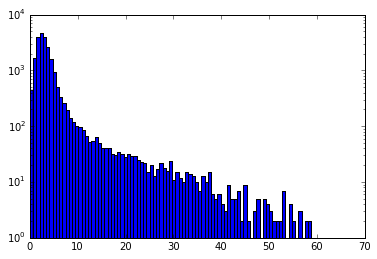

In [38]:
_=plt.hist(beh[0,:]-np.min(beh,axis=0),100)
plt.yscale('log')

### Step 4: model analysis and validation

#### histogram of rf models selected for each voxel
models with large indices are small rfs. so looks like we need higher resolution.

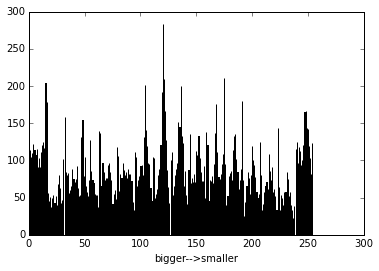

In [39]:
_=plt.hist(frf,2048)
plt.xlabel('bigger-->smaller')

#### sum of all selected rfs. 

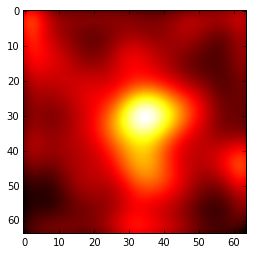

In [40]:
plt.imshow(np.sum(rf_stack[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy for all voxels

In [41]:
##grab validation data
val_voxel_data = voxel_data[valIdx,:]
val_model_space = model_space[:,valIdx,:]

In [42]:
##generate predictions one voxel at a time
pred = np.zeros((Tval,V))
for v in range(V-1):  ##<<some kind of bug in training function, last voxel getting skipped.
    pred[:,v] = np.squeeze(bigmult(val_model_space[np.newaxis,frf[v],:,:],
                                   ffw[np.newaxis,:,v, np.newaxis]))

In [43]:
##get correlation = prediction accuracy
val_cc = []  
for v in range(V-1): 
    cc = pearsonr(val_voxel_data[:,v],pred[:,v])
    if not np.isnan(cc[0]):
        val_cc.append(cc[0])

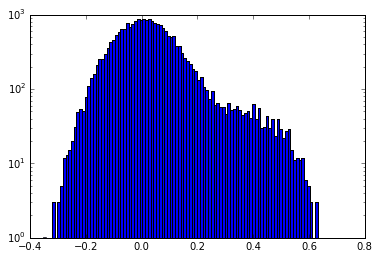

In [44]:
##histogram of prediction accuracy, all voxels
_=plt.hist(val_cc,100)
plt.yscale('log')